In [522]:
import numpy as np
from importlib import reload
from scipy import signal

import plotting_tools as pt
import utils
import dsi
utils = reload(utils)
pt = reload(pt)
dsi = reload(dsi)

import pickle
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../RKLM_Python/')

from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib import rc

# activate latex text rendering
rc('text', usetex=True)

In [523]:
Nx, Ny = 301, 20
# Nx, Ny = 1201, 80
ib = False

N = 1

def load(Nx,Ny,et):
    base_fn = 'output_baldauf_brdar'
    pydir = '../%s/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et)
    tags = tc.get_tag_dict()
    
    return tc, tags

i2 = (slice(2,-2),slice(2,-2))

long_hydro_imbal_best
long_hydro_imbal_best
(18, 2)


/home/ray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ray/git-projects/RKLM_Reference/visualiser_debugger/plotting_tools.py:160: UserWarning: No contour levels were found within the data range.
  im = cax.contour(arr,colors='k')


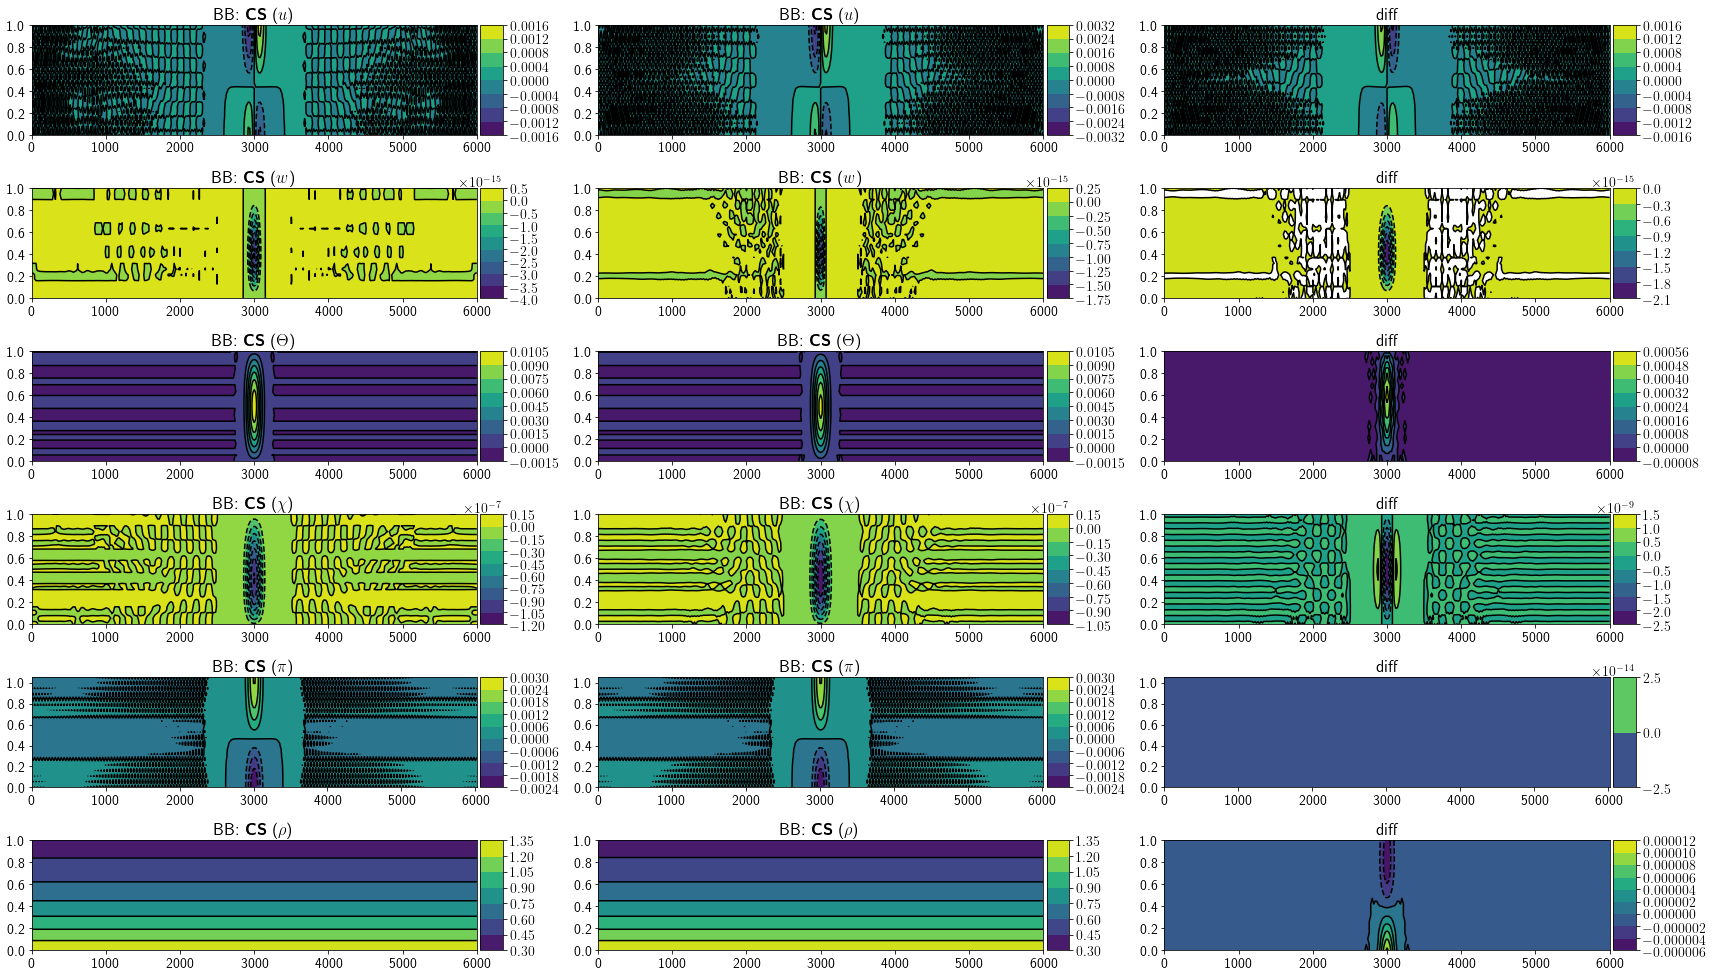

In [565]:
l_typ = 'WINDOW_STEP'
diff = False

attr_labels = pt.labels()

def get_ens(tc, times, sfx , diff, attribute, tag):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=False)[1]

    label = sfx + '_' + attribute
    return label, ens.T

def get_arr(typ, times, tp='half', attrs='all'):
    et = 39.4
    sfx1 = 'long_%s' %typ
    if ib: sfx1 = '%s_ib-0' %sfx1
    print(sfx1)

    tc, tags = load(Nx,Ny,et)
    if tp=='afs':
        tag = 'after_full_step'
    else:
        tag = tp

    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx1,format='dat')
    path_pickle = tc.get_path(fn_pickle)

    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    mpv = pickle.load(file)
    dap = pickle.load(file)
    elem = pickle.load(file)
    file.close()

    S0 = (ud.stratification(elem.y)).reshape(-1,1)
    
    if attrs == 'all':
        attributes = ['rhou', 'rhov', 'rhoY', 'rhoX', 'p2_nodes']
    else:
        attributes = ['pwchi']
    _, rho = get_ens(tc, times, sfx1, diff, 'rho', tag)
    la = r'BB: '
    if 'best' in typ:
        la += r'\textbf{CS}'
    elif 'imbal' in typ:
        la += r'\textbf{NS}'
    else:
        la += r'\textbf{ref}'
#     la = la + '_' + typ
    ret = []
    
    for attribute in attributes:
        _, aa = get_ens(tc, times, sfx1, diff, attribute, tag)

        
        if attribute == 'rhoY':
            aa = aa / rho
            aa -= S0
            aa = aa[i2] * ud.T_ref
            la_curr = la + r' ($\Theta$)'
        elif attribute == 'rhoX':
            aa = aa / rho
            aa = aa[i2] / ud.T_ref
            la_curr = la + r' ($\chi$)'
        elif attribute == 'rhou':
            aa = aa / rho
            aa = aa[i2] * ud.u_ref
            la_curr = la + r' ($u$)'
        elif attribute == 'rhov':
            aa = aa / rho
            _, rhoX = get_ens(tc, times, sfx1, diff, 'rhoX', tag)
#             Y = rhoY / rho
            aa = aa * rhoX 
            aa = aa[i2] * ud.rho_ref * ud.u_ref / ud.T_ref 
#             aa = aa[i2] * ud.u_ref #* ud.rho_ref * ud.T_ref * Y[i2]
#             dz = np.diff(elem.y)[0]
#             dz = (dz * ud.h_ref)
            aa /= (ud.h_ref)
#             aa = np.gradient(aa,dz,axis=1)
            la_curr = la + r' ($w$)'
        elif attribute == 'p2_nodes':
            aa = aa[i2]
            la_curr = la + r' ($\pi$)'
        elif attribute == 'pwchi':
            ts = 0.3416356 * 0.5 # 0.25*dt
            dz = np.diff(elem.y)[0]
#             dz = (dz * ud.h_ref)
            _, rhoY = get_ens(tc, times, sfx1, diff, 'rhoY', tag)
#             Y = rhoY / rho
            _, rhoX = get_ens(tc, times, sfx1, diff, 'rhoX', tag)
#             aa = aa / rhoX / ts * dz
#             aa = aa[i2] * ud.u_ref
            aa = aa / ts
            aa = aa[i2] * ud.rho_ref * ud.u_ref / ud.T_ref / ud.h_ref
        
#             aa = aa[i2] * Y[i2] * ud.u_ref * ud.rho_ref / ts

#             aa = aa[i2] * ud.u_ref * ud.rho_ref / ud.T_ref * ud.t_ref
            la_curr = la
        else:
            la_curr = la
        
        ret.append([aa,la_curr])
    
    rho = rho[i2] * ud.rho_ref
    ret.append([rho,la + r' ($\rho$)'])
    return np.array(ret)

# typ1 = 'nonhydro_imbal'
typ1 = 'hydro_imbal_best'
# typ1 = 'hydro'
typ2 = 'hydro_imbal_best'
# typ2 = 'nonhydro_imbal_best_ib-0'
times = [0]

aa1 = get_arr(typ1,times, tp='quarter')
aa2 = get_arr(typ2,times, tp='half')

diffs = []
for i in range(len(aa1)):
    diffs.append([aa1[i][0]-aa2[i][0], 'diff'])
    
pl_lst = np.array(list(zip(aa1,aa2,diffs))).reshape(18,2)
# pl_lst = np.array(diffs)

print(pl_lst.shape)

fac = 1.0
# pl = pt.plotter(pl_lst,ncols=2,figsize=(16*fac,9*fac),sharey=False)
pl = pt.plotter(pl_lst,ncols=3,figsize=(24*fac,15*fac),sharey=False)
x_axs = np.array([0,1000,2000,3000,4000,5000,6000])
# y_axs = [-0.5,-0.25,0.0,0.25,0.5]
y_axs = np.array([0.0,2.0,4.0,6.0,8.0,10.0]) / 10.0
x_loc = np.linspace(0,Nx-1,7)
y_loc = np.linspace(0,Ny-1,6)
# x_label = r'x [$\times 10$ km]'
# y_label = r'y [$\times 10$ km]'

pl.set_axes(y_locs=y_loc,y_axs=y_axs, x_locs=x_loc,x_axs=x_axs)
# pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
_ = pl.plot(method='contour', lvls=None)

# lbl = 'swe' if swe else 'euler'
# pl.save_fig('initial_vortex_%s' %lbl)

/home/ray/git-projects/RKLM_Reference/visualiser_debugger/plotting_tools.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.arr_lst = np.array(arr_lst)


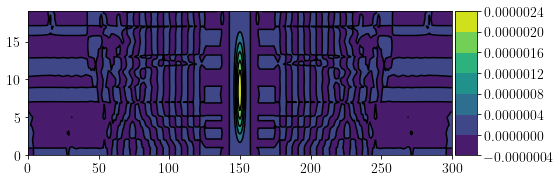

In [334]:
Y = aa1[2][0]
rho = aa1[5][0]
v = aa1[1][0]
rhoYv = rho * Y * v
pl1 = [[rhoYv,'']]
fac = 1.0
pl = pt.plotter(pl1,ncols=1,figsize=(8*fac,3*fac),sharey=False)
_ = pl.plot(method='contour', lvls=None)


long_hydro
long_hydro_imbal_best
long_hydro_imbal


/home/ray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


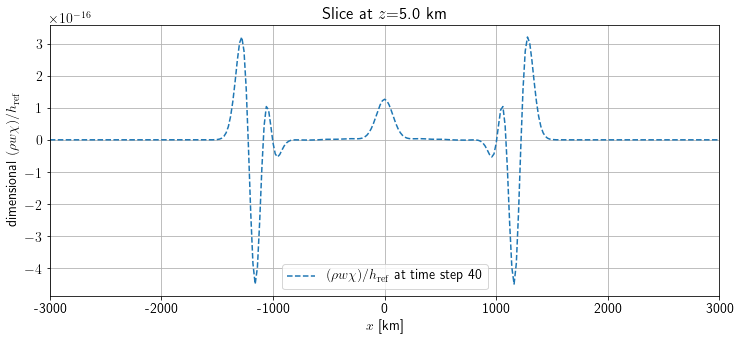

In [568]:
idx_dic = {
    'u' : 0,
    'v' : 1,
    'Y' : 2,
    'X' : 3,
    'p2n' : 4,
    'rho' : 5
}

typ_notbest = 'hydro'
# typ_notbest = 'nonhydro_imbal'
typ_best = 'hydro_imbal_best'
typ_3 = 'hydro_imbal'
times = [40]
notbest = get_arr(typ_notbest,times, tp='afs')
best = get_arr(typ_best,times, tp='afs')
t3 = get_arr(typ_3,times, tp='afs')

idx = idx_dic['v']
slc = 10
# slch = slice(70,90)
slch = slice(None,)
v_notbest = notbest[idx][0][slc][slch]
v_best = best[idx][0][slc][slch]
v_t3 = t3[idx][0][slc][slch]

slc_dist = slc / 20.0 * 10

plt.figure(figsize=(12,5))
# plt.plot(v_notbest, 'k', lw=2, label=r'hydrostatic with bal. IC (\textbf{ref})')
# plt.plot(v_best, '-', markevery=4, ms=4, label=r"hydrostatic with imbal. IC (\textbf{CS})")
# plt.plot(v_t3, '--', label=r"hydrostatic with imbal. IC (\textbf{NS})")
plt.plot(v_t3, '--', label=r"$(\rho w \chi) / h_{\rm ref}$ at time step %i" %times[0])
plt.legend()
plt.title(r"Slice at $z$=%.1f km" %slc_dist)

plt.grid()
plt.xlim([0,300])
plt.xticks(np.arange(0,350,50), np.arange(-3000,4000,1000))
plt.ylabel(r'dimensional $(\rho w \chi) / h_{\rm ref}$')
plt.xlabel(r'$x$ [km]')
plt.show()

# Plot $Pw \chi$

long_hydro_imbal_best
long_hydro_imbal
long_hydro_imbal_best


/home/ray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


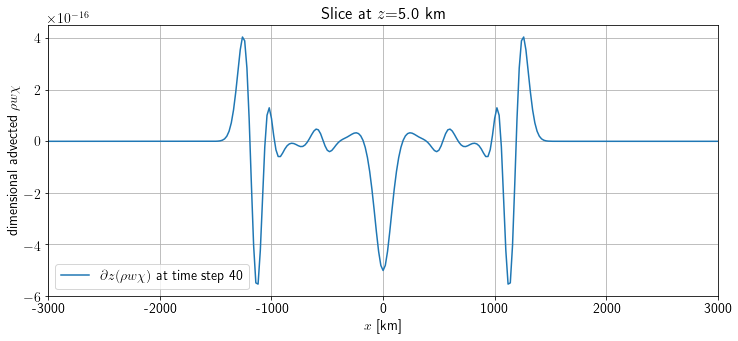

In [563]:
typ_notbest = 'hydro'
# typ_notbest = 'nonhydro_imbal'
typ_3 = 'hydro_imbal'
typ_best = 'hydro_imbal_best'

times0 = [0]
times1 = [40]
attrs = 'pchiw'
notbest = get_arr(typ_best,times0, tp='ic',attrs=attrs)
best = get_arr(typ_3,times1, tp='afs',attrs=attrs)
best1 = get_arr(typ_best,times1, tp='afs',attrs=attrs)

idx = idx_dic['X']
if attrs == 'pchiw':
    idx = 0
slc = 10
hslc = slice(130,170)
hslc = slice(None,)
v_notbest = notbest[idx][0][slc][hslc]
v_best = best[idx][0][slc][hslc]
v_t3 = best1[idx][0][slc][hslc]

slc_dist = slc / 20.0 * 10

plt.figure(figsize=(12,5))
# plt.plot(v_notbest, '-', lw=2, label=r'One 1st-order step at $t=0.50\,\Delta t$')
plt.plot(v_best, '-', markevery=4, ms=4, label=r"$\partial z (\rho w \chi)$ at time step %i" %times1[0])

# plt.plot(v_best, '-', label=r"$\partial z (\rho w \chi)$ at $t=0.0$")
# plt.plot(v_t3, '--', label=r"$\partial z (\rho w \chi)$ at $t=0.25\,\Delta t$")

# plt.plot(v_t3, 'C2-', label=r"$\partial z (\rho w \chi)$ at $t=0.25\,\Delta t$")
plt.legend()
plt.title(r"Slice at $z$=%.1f km" %slc_dist)

plt.grid()
plt.xlim([0,300])
plt.xticks(np.arange(0,350,50), np.arange(-3000,4000,1000))
plt.ylabel(r'dimensional advected $\rho w\chi$')
plt.xlabel(r'$x$ [km]')
plt.show()

# Skamarock-Klemp waves

In [183]:
Nx, Ny = 301, 10
# Nx, Ny = 1201, 80
ib = False

N = 1

def load(Nx,Ny,et):
    base_fn = 'output_internal_long_wave'
    pydir = '../%s/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et)
    tags = tc.get_tag_dict()
    
    return tc, tags

i2 = (slice(2,-2),slice(2,-2))

planetary_hydro_imbal
planetary_nonhydro
(15, 2)


/home/ray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


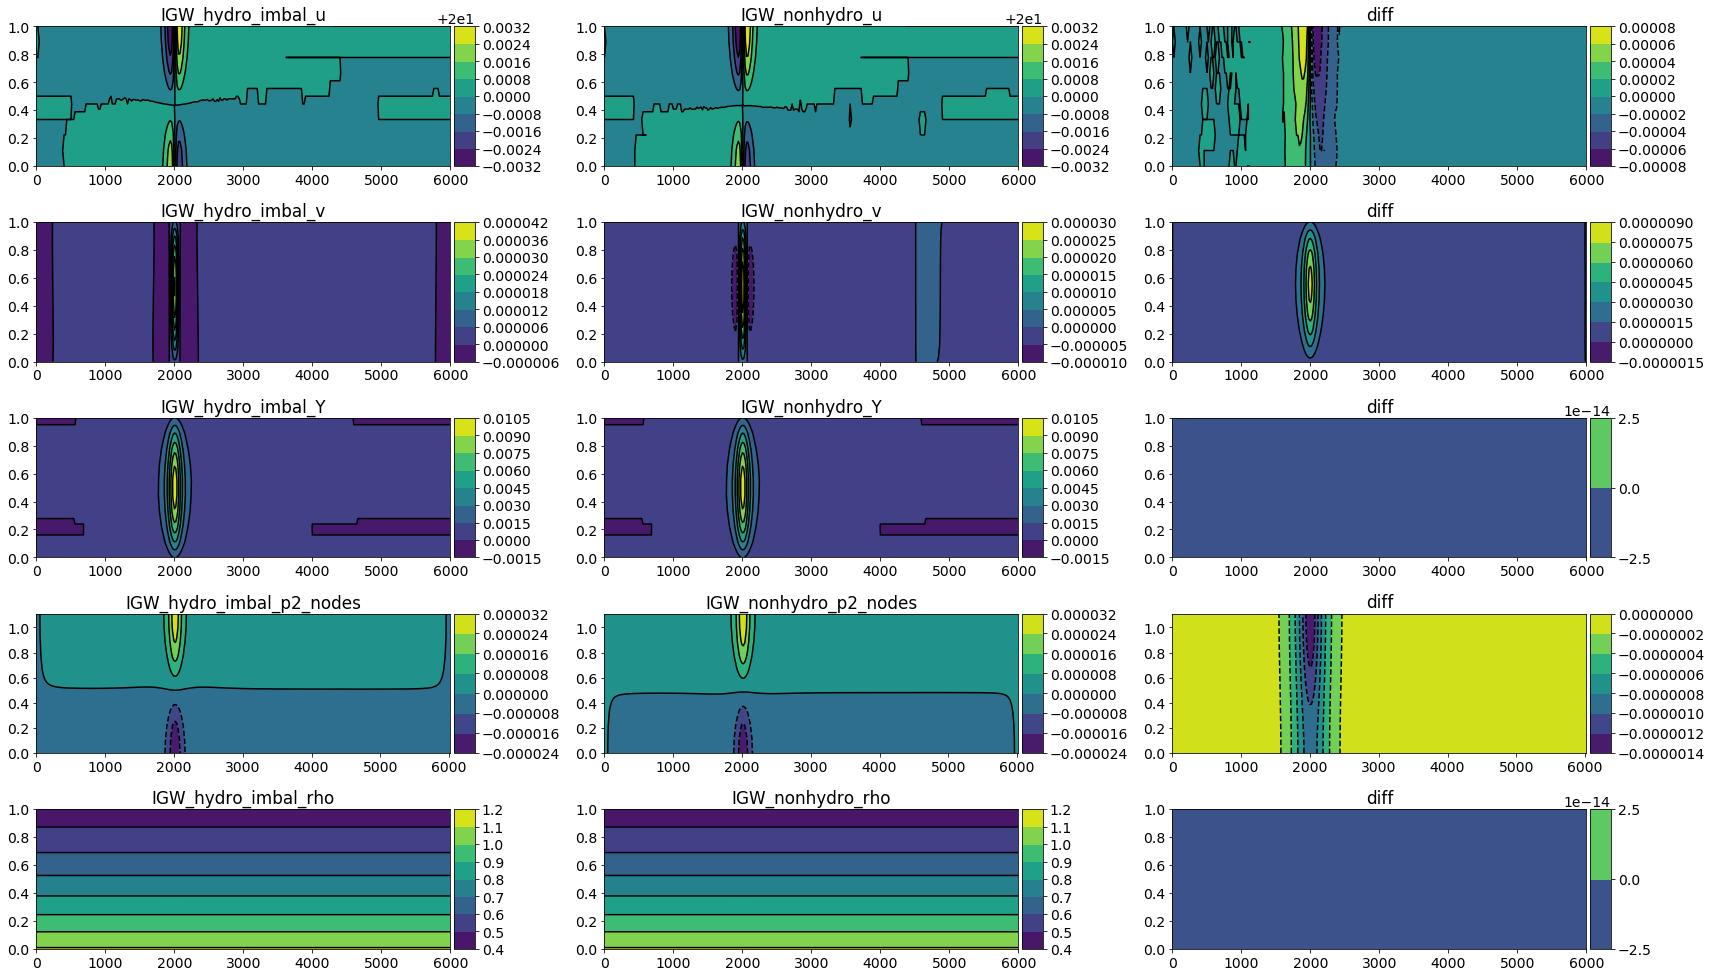

In [206]:
l_typ = 'WINDOW_STEP'
diff = False

long = False
planetary = True

attr_labels = pt.labels()

def get_ens(tc, times, sfx , diff, attribute, tag):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=False)[1]

    label = sfx + '_' + attribute
    return label, ens.T

def get_arr(typ, times, tp='half'):
    if long:
        et = 600.0
        sfx1 = 'long_%s' %typ
    elif planetary:
        et = 4800.0
        sfx1 = 'planetary_%s' %typ
    if ib: sfx1 = '%s_ib-0' %sfx1
    print(sfx1)

    tc, tags = load(Nx,Ny,et)
    if tp=='afs':
        tag = 'after_full_step'
    else:
        tag = tp

    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx1,format='dat')
    path_pickle = tc.get_path(fn_pickle)

    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    mpv = pickle.load(file)
    dap = pickle.load(file)
    elem = pickle.load(file)
    file.close()

    S0 = (ud.stratification(elem.y)).reshape(-1,1)
    
    attributes = ['rhou', 'rhov', 'rhoY', 'p2_nodes']
    _, rho = get_ens(tc, times, sfx1, diff, 'rho', tag)
    la = 'IGW'
    la = la + '_' + typ
    ret = []
    
    for attribute in attributes:
        _, aa = get_ens(tc, times, sfx1, diff, attribute, tag)
        if attribute != 'p2_nodes':
            la_curr = la + '_' + attribute[-1]
        else:
            la_curr = la + '_' + attribute
        
        if attribute == 'rhoY':
            aa = aa / rho
            aa -= S0
            aa = aa[i2] * ud.T_ref
        elif attribute == 'rhou':
            aa = aa / rho
            aa = aa[i2] * ud.u_ref
        elif attribute == 'rhov':
            aa = aa / rho
            aa = aa[i2] * ud.u_ref
        elif attribute == 'p2_nodes':
            aa = aa[i2]
        
        ret.append([aa,la_curr])
    
    rho = rho[i2] * ud.rho_ref
    ret.append([rho,la+'_rho'])
    return np.array(ret)

# typ1 = 'nonhydro'
typ1 = 'nonhydro'
# typ2 = ''
typ2 = 'hydro_imbal'
times = [0]

aa1 = get_arr(typ2,times, tp='half')
aa2 = get_arr(typ1,times, tp='half')

diffs = []
for i in range(len(aa1)):
    diffs.append([aa1[i][0]-aa2[i][0], 'diff'])
    
pl_lst = np.array(list(zip(aa1,aa2,diffs))).reshape(15,2)
# pl_lst = np.array(diffs)

print(pl_lst.shape)

fac = 1.0
# pl = pt.plotter(pl_lst,ncols=2,figsize=(16*fac,9*fac),sharey=False)
pl = pt.plotter(pl_lst,ncols=3,figsize=(24*fac,15*fac),sharey=False)
x_axs = np.array([0,1000,2000,3000,4000,5000,6000])
# y_axs = [-0.5,-0.25,0.0,0.25,0.5]
y_axs = np.array([0.0,2.0,4.0,6.0,8.0,10.0]) / 10.0
x_loc = np.linspace(0,Nx-1,7)
y_loc = np.linspace(0,Ny-1,6)
# x_label = r'x [$\times 10$ km]'
# y_label = r'y [$\times 10$ km]'

pl.set_axes(y_locs=y_loc,y_axs=y_axs, x_locs=x_loc,x_axs=x_axs)
# pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
_ = pl.plot(method='contour', lvls=None)

# lbl = 'swe' if swe else 'euler'
# pl.save_fig('initial_vortex_%s' %lbl)

planetary_hydro
planetary_hydro_imbal_best


/home/ray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


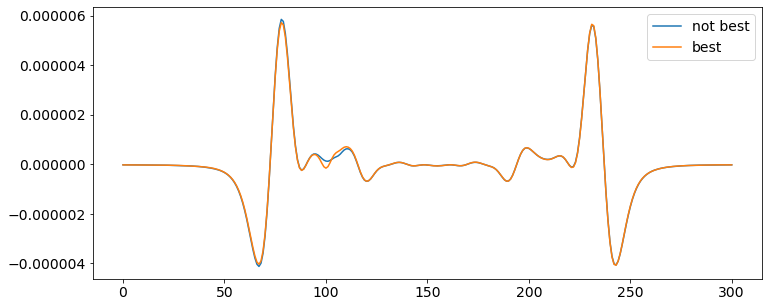

In [193]:
idx_dic = {
    'u' : 0,
    'v' : 1,
    'Y' : 2,
    'p2n' : 3,
    'rho' : 4
}

typ_notbest = 'hydro'
typ_best = 'hydro_imbal_best'
times = [60]
notbest = get_arr(typ_notbest,times, tp='afs')
best = get_arr(typ_best,times, tp='afs')

idx = idx_dic['v']
slc = 9
v_notbest = notbest[idx][0][slc]
v_best = best[idx][0][slc]

plt.figure(figsize=(12,5))
plt.plot(v_notbest, label='not best')
plt.plot(v_best, label='best')
plt.legend()
plt.show()